In [1]:
import wandb
from datetime import datetime

In [2]:
lr = 5e-4
batch_size = 8
wd = 1e-5
image_size = 512
backbone='efficientdetv2_ds'
vertical_type = "sagittal"
train_portion = 0.5
milestones = [50, 100, 150, 200]
model_name = "effdet"
epochs = 2

In [3]:
wandb_entity='longyi'
model_name = "effdet"
wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "backbone" : backbone,
    "image_size" : image_size,
})
wandb.run.name = f'sagittal_detection_{model_name}_' + datetime.now().strftime("%H%M%S")
wandb.run.name

wandb: Currently logged in as: longyi. Use `wandb login --relogin` to force relogin


'sagittal_detection_effdet_112841'

In [4]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms

# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

# from sklearn.model_selection import GroupKFold



# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_sagittal_images_jpeg95')

In [6]:
bbox_df = pd.read_csv(os.path.join(DATA_DIR, 'sagittal_bbox.csv')).set_index('UID')
print(len(bbox_df))
bbox_df.head()

223


,sagittal_index,xmin,ymin,xmax,ymax,aspect
UID,,,,,,
1.2.826.0.1.3680043.10051,222,212.24727,324.923397,282.06546,361.846510,2.461541
1.2.826.0.1.3680043.10579,267,244.96552,234.666667,287.52072,240.761905,3.047619
1.2.826.0.1.3680043.10678,144,252.58667,202.298851,291.00000,220.689655,3.065134
1.2.826.0.1.3680043.10697,238,112.71642,467.153285,163.77748,493.313869,3.737226
1.2.826.0.1.3680043.10815,200,318.77395,265.882353,403.28567,301.176471,2.352941


In [7]:
xywh = bbox_df[['xmin','ymin','xmax','ymax']].values
xywh[:, 2] = xywh[:, 2] - xywh[:, 0]
xywh[:, 3] = xywh[:, 3] - xywh[:, 1]

bbox_df[['x','y','width','height']] = xywh
bbox_df = bbox_df.drop(['xmin','ymin','xmax','ymax'], axis=1)

bbox_df = bbox_df[(bbox_df.width > 10) & (bbox_df.height > 10)]

print(len(bbox_df))
bbox_df.head()

186


,sagittal_index,aspect,x,y,width,height
UID,,,,,,
1.2.826.0.1.3680043.10051,222,2.461541,212.24727,324.923397,69.81819,36.923113
1.2.826.0.1.3680043.10678,144,3.065134,252.58667,202.298851,38.41333,18.390805
1.2.826.0.1.3680043.10697,238,3.737226,112.71642,467.153285,51.06106,26.160584
1.2.826.0.1.3680043.10815,200,2.352941,318.77395,265.882353,84.51172,35.294118
1.2.826.0.1.3680043.11103,192,2.994152,132.16825,143.719298,71.90231,23.953216


In [8]:
def square_crop_position(crop_box, image_size=512):
    """
    crop box 를 정방형으로 만들어준다.
    :param left:
    :param top:
    :param right:
    :param bottom:
    :param image_size:
    :return:
    """
    left, top, right, bottom = crop_box
    w, h = right - left, bottom - top

    if h > w:
        left_pad = (h - w) // 2
        right_pad = h - w - left_pad
        left -= left_pad
        right += right_pad

        if left < 0:
            right -= left
            left = 0
        elif right > image_size:
            left -= right - image_size
            right = image_size
    else:
        top_pad = (w - h) // 2
        bottom_pad = w - h - top_pad
        top -= top_pad
        bottom += bottom_pad

        if top < 0:
            bottom -= top
            top = 0
        elif bottom > image_size:
            top -= bottom - image_size
            bottom = image_size
    return left, top, right, bottom


square_crop_position([0, 1, 2, 4], image_size=5)

(0, 1, 3, 4)

In [9]:
sagittal_boundary_df = pd.read_csv(os.path.join(DATA_DIR, 'infer_sagittal_boundary.csv')).set_index('UID')
sagittal_boundary_df['ymax'] = sagittal_boundary_df[['height','ymax']].min(axis=1)
sagittal_boundary_df['xmax'] = sagittal_boundary_df[['width','xmax']].min(axis=1)
print(len(sagittal_boundary_df))
sagittal_boundary_df.head()

2012


,Unnamed: 0,height,width,xmin,ymin,xmax,ymax
UID,,,,,,,
1.2.826.0.1.3680043.10001,0,659,512,47.024193,71.835014,420.97748,620.1517
1.2.826.0.1.3680043.10005,1,541,512,63.075333,10.491298,460.40836,411.9475
1.2.826.0.1.3680043.10014,2,882,512,11.231842,91.550030,506.54834,843.6671
1.2.826.0.1.3680043.10016,3,733,512,27.175400,41.369190,438.84436,631.6106
1.2.826.0.1.3680043.10032,4,626,512,30.145882,57.993862,443.24400,604.6150


In [10]:
sagittal_boundary_df.loc['1.2.826.0.1.3680043.17787']

Unnamed: 0    511.000000
height        366.000000
width         512.000000
xmin           64.715290
ymin           20.636284
xmax          361.119230
ymax          366.000000
Name: 1.2.826.0.1.3680043.17787, dtype: float64

In [11]:
pos_boundary_df = sagittal_boundary_df.loc[bbox_df.index.unique(), ['xmin','ymin','xmax','ymax']]

pos_df = pd.concat((pos_boundary_df, bbox_df), axis=1)

print(len(pos_df))
pos_df.head()

186


,xmin,ymin,xmax,ymax,sagittal_index,aspect,x,y,width,height
UID,,,,,,,,,,
1.2.826.0.1.3680043.10051,40.741394,34.194770,422.72394,617.87680,222,2.461541,212.24727,324.923397,69.81819,36.923113
1.2.826.0.1.3680043.10678,33.380800,94.329100,484.04065,767.95685,144,3.065134,252.58667,202.298851,38.41333,18.390805
1.2.826.0.1.3680043.10697,36.726470,118.365690,428.62190,648.48630,238,3.737226,112.71642,467.153285,51.06106,26.160584
1.2.826.0.1.3680043.10815,172.785190,35.653275,512.00000,539.81220,200,2.352941,318.77395,265.882353,84.51172,35.294118
1.2.826.0.1.3680043.11103,70.477490,80.711450,424.76790,578.11444,192,2.994152,132.16825,143.719298,71.90231,23.953216


In [33]:
pos_df.to_csv(os.path.join(DATA_DIR, 'train_sagittal_bbox.csv'))

wandb: Waiting for W&B process to finish... (success).


In [12]:
neg_train_df = pd.read_csv(os.path.join(DATA_DIR, 'train_df_with_slices.csv')).set_index('UID')
neg_train_df = neg_train_df[neg_train_df.patient_overall == 0]
print(len(neg_train_df))
neg_train_df.head()


1056


,patient_overall,C1,C2,C3,C4,C5,C6,C7,num_slices
UID,,,,,,,,,
1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,501
1.2.826.0.1.3680043.17364,0,0,0,0,0,0,0,0,297
1.2.826.0.1.3680043.849,0,0,0,0,0,0,0,0,571
1.2.826.0.1.3680043.24946,0,0,0,0,0,0,0,0,571
1.2.826.0.1.3680043.9290,0,0,0,0,0,0,0,0,223


In [13]:
coronal_boundary_df = pd.read_csv(os.path.join(DATA_DIR, 'infer_coronal_boundary.csv')).set_index('UID')

print(len(coronal_boundary_df))
coronal_boundary_df.head()

2012


,Unnamed: 0,height,width,xmin,ymin,xmax,ymax
UID,,,,,,,
1.2.826.0.1.3680043.10001,0,659,512,78.849180,67.13144,453.30298,628.84390
1.2.826.0.1.3680043.10005,1,541,512,93.988910,9.36849,373.98172,409.21265
1.2.826.0.1.3680043.10014,2,882,512,22.234573,118.48294,500.32007,843.86930
1.2.826.0.1.3680043.10016,3,733,512,73.564575,46.92755,444.91382,612.70056
1.2.826.0.1.3680043.10032,4,626,512,85.200000,91.15128,420.28073,607.54380


In [14]:
neg_coronal_boundary = coronal_boundary_df.loc[neg_train_df.index.unique()]
# print(len(neg_coronal_boundary))
# neg_coronal_boundary.head()

neg_df = pd.DataFrame()
neg_df[['start_index','end_index']] = neg_coronal_boundary[['xmin','xmax']]
print(len(neg_df))

neg_boundary_df = sagittal_boundary_df.loc[neg_df.index.unique(), ['xmin','ymin','xmax','ymax']]
neg_df = pd.concat((neg_boundary_df, neg_df), axis=1)

neg_df.head()



1056


,xmin,ymin,xmax,ymax,start_index,end_index
UID,,,,,,
1.2.826.0.1.3680043.12351,75.061860,102.222580,484.60437,708.46936,48.840805,450.27026
1.2.826.0.1.3680043.17364,57.516968,96.798645,438.75427,645.43896,87.363174,438.60242
1.2.826.0.1.3680043.849,24.123108,46.566290,370.84195,634.00550,99.445860,434.40997
1.2.826.0.1.3680043.24946,2.235985,24.483335,330.14930,568.25150,107.752780,442.44165
1.2.826.0.1.3680043.9290,77.983950,141.493700,405.67218,747.98380,40.278090,422.49097


Only pick same size negative cases

In [15]:
def crop_image(img:Image, bbox, crop_box):
    """

    :param img:
    :param bbox: [left, top, right, bottom]
    :param crop_box:[left, top, right, bottom]
    :return:
    """
    left, top, right, bottom = crop_box
    img = img.crop(crop_box)
    bbox[0] -= left
    bbox[1] -= top
    bbox[2] -= left
    bbox[3] -= top

    return img, bbox

[108.54817, 457.0201342281879, 172.1727, 68.72483221476512]


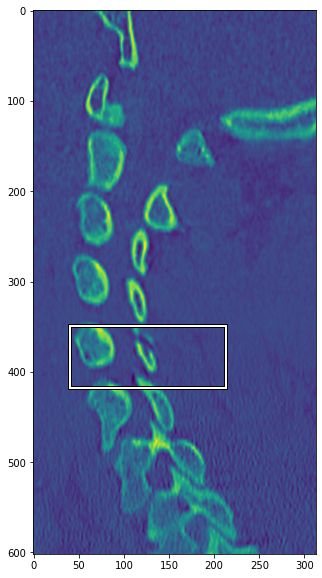

In [16]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return xmin_top_left, ymax_bottom_right, width, height


def draw_pascal_voc_bboxes(
        plot_ax,
        bbox,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    x, y, width, height = get_rectangle_corners_fn(bbox)

    rect_1 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=4,
        edgecolor="black",
        fill=False,
    )
    rect_2 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=2,
        edgecolor="white",
        fill=False,
    )

    # Add the patch to the Axes
    plot_ax.add_patch(rect_1)
    plot_ax.add_patch(rect_2)


def show_image(
        image, bbox=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    draw_bboxes_fn(ax, bbox)

    plt.show()


s = pos_df.iloc[13]
image = Image.open(os.path.join(IMAGES_DIR, s.name, f'{int(s.sagittal_index)}.jpeg'))
bbox = list(s[['x', 'y','width','height']])
print(bbox)
bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
crop_box = s[['xmin','ymin','xmax','ymax']]
image, bbox = crop_image(image, bbox, crop_box)
show_image(image, bbox)

## Dataset

In [17]:
class FractureDatasetAdaptor(Dataset):
    def __init__(self, images_dir_path, pos_df, neg_df):
        self.image_dir = images_dir_path
        self.pos_df = pos_df
        self.neg_df = neg_df

    def __len__(self) -> int:
        return len(self.pos_df) * 2

    def get_image_and_labels_by_idx(self, idx):
        
        is_pos = (idx % 2) == 0
        
        if is_pos:
            s = self.pos_df.iloc[idx // 2]
            slice = int(s['sagittal_index'])
        else:
            rand_idx = np.random.randint(0, len(self.neg_df))
            s = self.neg_df.iloc[rand_idx]
            slice = np.random.randint(int(s.start_index), int(s.end_index))
            # print(s)
        # img = Image.open(os.path.join(self.images_dir_path, s['StudyInstanceUID'], f"{s['axial_index']}.jpeg"))
        # print(s)
        UID = s.name
        # print(s)
        
        r = Image.open(os.path.join(self.image_dir, UID, f"{slice-1}.jpeg"))
        g = Image.open(os.path.join(self.image_dir, UID, f"{slice-0}.jpeg"))
        b = Image.open(os.path.join(self.image_dir, UID, f"{slice+1}.jpeg"))
        img = Image.merge('RGB', (r, g, b))
        
        if is_pos:
            pascal_bboxes = [[s.x, s.y, s.x + s.width, s.y + s.height]]
            class_labels = np.ones(1)
        else:
            pascal_bboxes = []
            class_labels = []

        crop_box = s[['xmin','ymin','xmax','ymax']].values
        return img, pascal_bboxes, class_labels, idx, crop_box

    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image(image, bboxes)
        print(class_labels)

da = FractureDatasetAdaptor(IMAGES_DIR, pos_df, neg_df)
len(da)
da.get_image_and_labels_by_idx(270)

(<PIL.Image.Image image mode=RGB size=512x717 at 0x7F813C10EE80>,
 [[147.70973, 395.0419112788577, 252.0, 411.2321535443847]],
 array([1.]),
 270,
 array([123.628174, 114.00455 , 382.74246 , 586.61957 ]))

## Transform

{'bboxes': tensor([[ 45.0881, 217.6609, 133.7386, 489.6647]]), 'labels': tensor([1.], dtype=torch.float64), 'image_id': tensor([210]), 'img_size': (512, 512), 'img_scale': tensor([1.])}


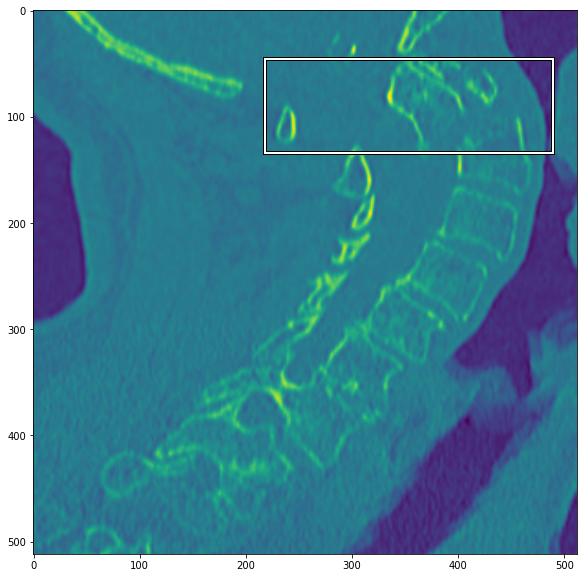

In [18]:
def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            # A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            # A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


class EfficientDetDataset(Dataset):
    def __init__(
            self, dataset_adaptor, transforms=get_valid_transforms()
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id,
            crop_box
        ) = self.ds.get_image_and_labels_by_idx(index)

        if len(pascal_bboxes) > 0:
            image, pascal_bboxes = crop_image(image, pascal_bboxes[0], crop_box)
            pascal_bboxes[0] = max(0, pascal_bboxes[0])
            pascal_bboxes[1] = max(0, pascal_bboxes[1])
            pascal_bboxes[2] = min(image.width, pascal_bboxes[2])
            pascal_bboxes[3] = min(image.height, pascal_bboxes[3])
            
            sample = {
                "image": np.array(image, dtype=np.float32),
                "bboxes": [pascal_bboxes],
                "labels": class_labels,
            }
            sample = self.transforms(**sample)
            sample["bboxes"] = np.array(sample["bboxes"])
            image = sample["image"]
            labels = sample["labels"]

            # print(sample)

            _, new_h, new_w = image.shape

            sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
                                            :, [1, 0, 3, 2]
                                            ]  # convert to yxyx

            target = {
                "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
                "labels": torch.as_tensor(labels),
                "image_id": torch.tensor([image_id]),
                "img_size": (new_h, new_w),
                "img_scale": torch.tensor([1.]),
            }
        else:
            image = image.crop(crop_box)   
            image = self.transforms(image=np.array(image, dtype=np.float32), bboxes=[], labels=[])["image"]
            _, new_h, new_w = image.shape
            target = {
                "bboxes": torch.zeros((0, 4)),
                "labels": torch.tensor([]),
                "image_id": torch.tensor([image_id]),
                "img_size": (new_h, new_w),
                "img_scale": torch.tensor([1.]),
            }
        
        

        return image, target, image_id

    def __len__(self):
        return len(self.ds)


train_dataset = EfficientDetDataset(da, transforms=get_train_transforms())
img, ann, idx = train_dataset[210]
print(ann)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img[0, :, :])

if len(ann['bboxes']) > 0:
    draw_pascal_voc_bboxes(ax, ann['bboxes'][0].cpu().numpy()[[1, 0, 3, 2]])


In [19]:
def collate_fn(batch):
    images, targets, image_ids = tuple(zip(*batch))
    images = torch.stack(images)
    images = images.float()

    boxes = [target["bboxes"].float() for target in targets]
    labels = [target["labels"].float() for target in targets]
    img_size = torch.tensor([target["img_size"] for target in targets]).float()
    img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

    annotations = {
        "bbox": boxes,
        "cls": labels,
        "img_size": img_size,
        "img_scale": img_scale,
    }

    return images, annotations, targets, image_ids

In [20]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    num_workers=min(os.cpu_count(), 16),
    collate_fn=collate_fn,
)

## Model

In [21]:
from effdet.config.model_config import efficientdet_model_param_dict
list(efficientdet_model_param_dict.keys())

['efficientdet_d0',
 'efficientdet_d1',
 'efficientdet_d2',
 'efficientdet_d3',
 'efficientdet_d4',
 'efficientdet_d5',
 'efficientdetv2_dt',
 'efficientdetv2_ds',
 'resdet50',
 'cspresdet50',
 'cspresdext50',
 'cspresdext50pan',
 'cspdarkdet53',
 'cspdarkdet53m',
 'mixdet_m',
 'mixdet_l',
 'mobiledetv2_110d',
 'mobiledetv2_120d',
 'mobiledetv3_large',
 'efficientdet_q0',
 'efficientdet_q1',
 'efficientdet_q2',
 'efficientdet_w0',
 'efficientdet_es',
 'efficientdet_em',
 'efficientdet_lite0',
 'tf_efficientdet_d0',
 'tf_efficientdet_d1',
 'tf_efficientdet_d2',
 'tf_efficientdet_d3',
 'tf_efficientdet_d4',
 'tf_efficientdet_d5',
 'tf_efficientdet_d6',
 'tf_efficientdet_d7',
 'tf_efficientdet_d7x',
 'tf_efficientdet_d0_ap',
 'tf_efficientdet_d1_ap',
 'tf_efficientdet_d2_ap',
 'tf_efficientdet_d3_ap',
 'tf_efficientdet_d4_ap',
 'tf_efficientdet_d5_ap',
 'tf_efficientdet_lite0',
 'tf_efficientdet_lite1',
 'tf_efficientdet_lite2',
 'tf_efficientdet_lite3',
 'tf_efficientdet_lite3x',
 'tf_ef

In [22]:
from effdet import create_model
model = create_model('efficientdetv2_ds' , bench_task='train' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

26374778


In [23]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

In [24]:
# images = torch.randn(2, 3, 512, 512).to(device)
# anns = {
#     'bbox' : [torch.randn((0, 4)).to(device), torch.randn((0, 4)).to(device)],
#     'cls' : [torch.tensor([]).to(device), torch.tensor([]).to(device)],
#     'image_size' : torch.ones((2, 2)).to(device) * 512.,
#     'img_scale' : torch.ones(2).to(device)
# }
# print(anns)
# loss_dict = model(images, anns)

# optimizer.zero_grad()
# loss_dict['loss'].backward()
# optimizer.step()

# loss_dict['loss'].item()

In [25]:
images, anns, _, image_ids = next(iter(train_loader))
print(anns)
print(images.shape)
images = images.to(device)
anns = {
    'bbox' : [tensor.to(device) for tensor in anns['bbox']],
    'cls' : [tensor.to(device) for tensor in anns['cls']],
    'img_size' : anns['img_size'].to(device),
    'img_scale' : anns['img_scale'].to(device)
}
model(images, anns)

{'bbox': [tensor([], size=(0, 4)), tensor([[221.0299, 160.3791, 250.7110, 271.8780]]), tensor([[290.9443, 214.3598, 343.7960, 418.9006]]), tensor([], size=(0, 4)), tensor([[114.9236, 300.9472, 160.9050, 373.1712]]), tensor([[ 60.2546, 222.6502, 124.2228, 457.6782]]), tensor([[303.0032, 113.3038, 330.6228, 254.6826]]), tensor([], size=(0, 4))], 'cls': [tensor([]), tensor([1.]), tensor([1.]), tensor([]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([])], 'img_size': tensor([[512., 512.],
        [512., 512.],
        [512., 512.],
        [512., 512.],
        [512., 512.],
        [512., 512.],
        [512., 512.],
        [512., 512.]]), 'img_scale': tensor([1., 1., 1., 1., 1., 1., 1., 1.])}
torch.Size([8, 3, 512, 512])


{'loss': tensor(2.3384, device='cuda:0', grad_fn=<AddBackward0>),
 'class_loss': tensor(1.3902, device='cuda:0', grad_fn=<SumBackward1>),
 'box_loss': tensor(0.0190, device='cuda:0', grad_fn=<SumBackward1>)}

In [26]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.5)


## Train one epoch

In [27]:
def train_one_epoch(e, model, dataloader):
    model.train()
    train_iter = tqdm(dataloader)
    loss_list = []
    epoch_iteration = len(dataloader)

    for i, (images, anns, _, _) in enumerate(train_iter):
        images = images.to(device)
        anns = {
            'bbox' : [tensor.to(device) for tensor in anns['bbox']],
            'cls' : [tensor.to(device) for tensor in anns['cls']],
            'img_size' : anns['img_size'].to(device),
            'img_scale' : anns['img_scale'].to(device)
        }

        with torch.cuda.amp.autocast(device == 'cuda'):
            losses = model(images, anns)
            loss, class_loss, box_loss = losses['loss'], losses['class_loss'], losses['box_loss']

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        scaler.step(optimizer)
        scaler.update()

        train_iter.set_description(f"t {e} loss {loss.item():.4f} c {class_loss.item():.4f} b {box_loss.item():.4f}")

        loss_list.append(loss.item())

        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss': loss.item(),
                'train_class_loss': class_loss.item(),
                'train_box_loss': box_loss.item(),
                'epoch': e,
                'train_iteration': i + e * epoch_iteration,
                **lr_logs,
            })

        # if i % 100 == 0:
        #     with torch.no_grad():
        #         inference(model, val_dataset)
        #         # infer_bad_sample(wandb_log=True)
        #     model.train()

    return np.mean(loss_list)

In [28]:
epoch = 0

In [31]:
for e in range(20):

    train_loss = train_one_epoch(epoch, model, train_loader)

    # with torch.no_grad():
    #     evaluate(epoch, model, val_loader)


    epoch += 1
    scheduler.step()

t 23 loss 0.2616 c 0.1615 b 0.0020: 100%|██████████| 46/46 [00:16<00:00,  2.82it/s]


In [32]:
state = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "scheduler": scheduler.state_dict(),
    "epoch": epoch,
}
torch.save(state, os.path.join(DATA_DIR, f'checkpoint/{wandb.run.name}-epoch-{epoch}.pth'))

## Inference

In [ ]:
from torchvision.utils import draw_bounding_boxes
from effdet import DetBenchPredict

pred_model = DetBenchPredict(model.model).to(device)

In [ ]:
def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ]
    )
val_transform = get_valid_transforms()

In [ ]:
def get_image_and_labels_by_idx(image_dir, boundary_df, UID, slice):

    r = Image.open(os.path.join(image_dir, UID, f"{slice - 1}.jpeg"))
    g = Image.open(os.path.join(image_dir, UID, f"{slice - 0}.jpeg"))
    b = Image.open(os.path.join(image_dir, UID, f"{slice + 1}.jpeg"))
    img = Image.merge('RGB', (r, g, b))

    s = boundary_df.loc[UID]

    crop_box = s[['xmin', 'ymin', 'xmax', 'ymax']].values
    return img, crop_box

def infer_slice(pred_model, UID, slice, wandb_log=True):
    image, crop_box = get_image_and_labels_by_idx(IMAGES_DIR, boundary_df, UID, slice)
    image = image.crop(crop_box)
    transformed = val_transform(image=np.array(image, dtype=np.float32))
    image = transformed["image"]

    bboxes = pred_model(image.to(device).unsqueeze(0))[0]

    image = (image * 0.5 + 0.5) * 255
    image = image.to(torch.uint8)
    # print(list(bboxes[:1, :5]))
    bbox_image = draw_bounding_boxes(image, boxes=bboxes[:1, :4], colors='white')
    
    if wandb_log:
        wandb.log({
            'pred_image' : wandb.Image(bbox_image.permute(1, 2, 0).cpu().numpy())
        })
    else:
        plt.imshow(bbox_image.permute(1, 2, 0).cpu().numpy(), cmap='bone')

with torch.no_grad():
    infer_slice(pred_model, '1.2.826.0.1.3680043.1363', 113, wandb_log=True)
    # infer_slice(pred_model, '1.2.826.0.1.3680043.1363', 113, wandb_log=False)